In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip "/content/drive/MyDrive/Prodigy/archive (5).zip"

In [3]:
import tensorflow_datasets as tfds

In [4]:
list_datasets = tfds.list_builders()
print('food101' in list_datasets) # checking for our dataset presence

True


In [5]:
(train_data,test_data),df_info = tfds.load('food101',
                                           split=['train','validation'],
                                           shuffle_files=True,
                                           as_supervised=True,
                                           with_info=True)

## Dataset


In [6]:
#features of the dataset
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# getting the class names

class_names = df_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# lets see some info about images and labels
for img ,labels in train_data.take(1): # .take method will take one sample from the data and every time we rn these we get random values because we set shuffle = True
  print(f'''
  image shape: {img.shape}
  image dtype: {img.dtype}
  label : {labels}
  label name: {class_names[labels.numpy()]}
  '''
  )


  image shape: (512, 512, 3)
  image dtype: <dtype: 'uint8'>
  label : 49
  label name: grilled_cheese_sandwich
  


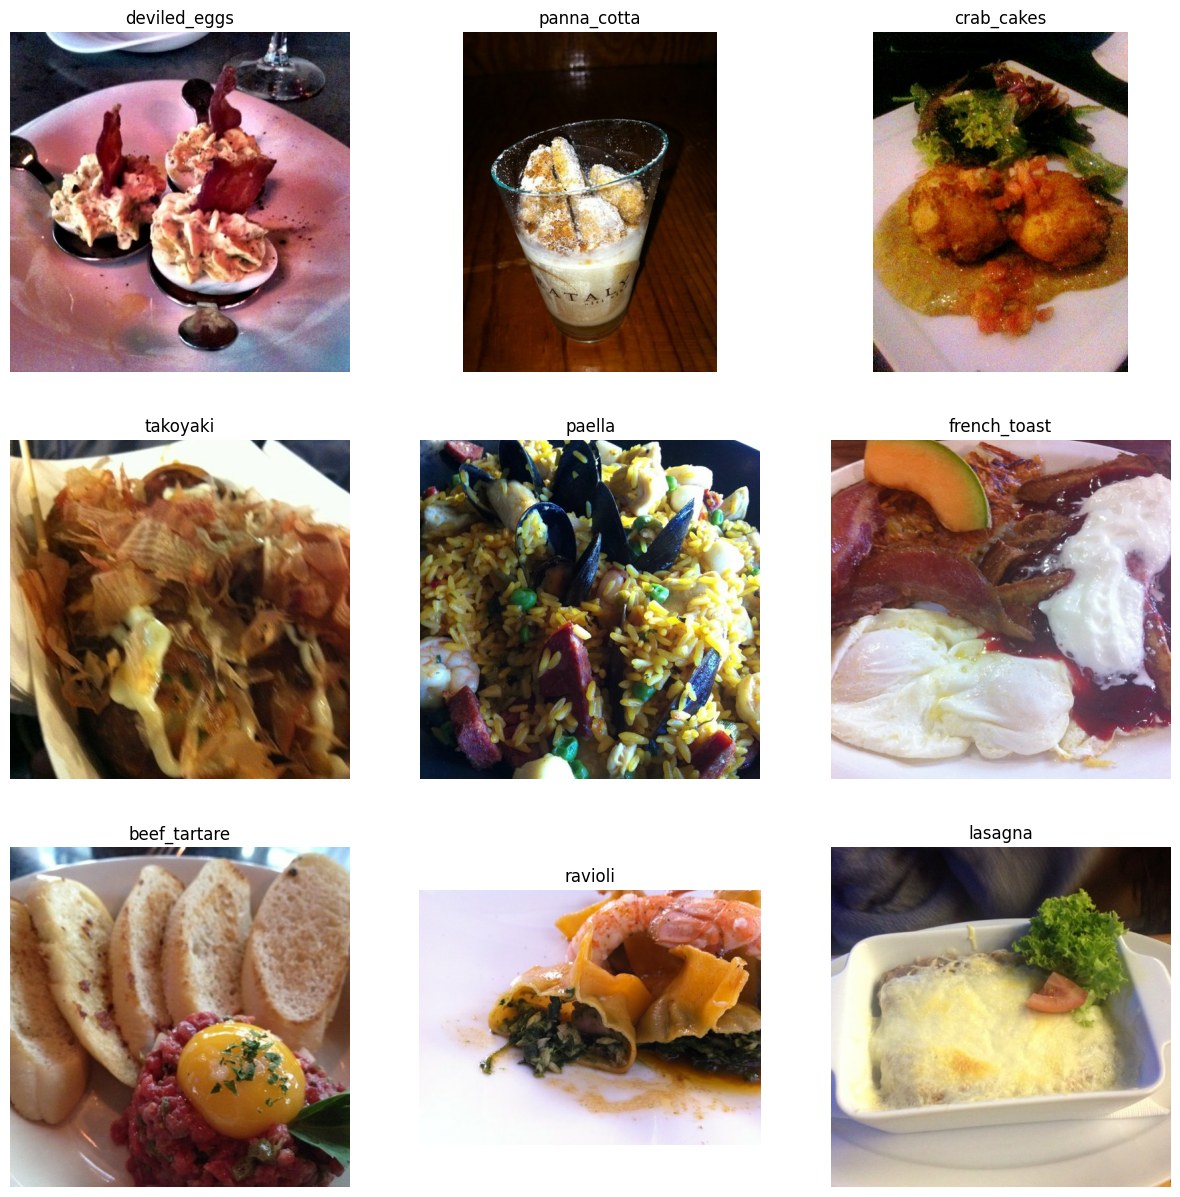

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i,(img ,labels) in enumerate(train_data.take(9)):
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(class_names[labels.numpy()])
  plt.axis(False)

In [10]:
def preprocess_image_data(images,labels,img_size=(224,224)):
  '''
  This function will reduce image size and change dtype int float32

  '''
  image  = tf.image.resize(images,img_size)

  return tf.cast(image,dtype=tf.float32),labels

In [11]:
prep_img ,label = preprocess_image_data(img,labels)

print(f'image_shape : {prep_img.shape} image_dtype : {prep_img.dtype} ')

image_shape : (224, 224, 3) image_dtype : <dtype: 'float32'> 


As you can see the image is resized and dtype is changed

In [12]:
train_data = train_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data  = test_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [14]:
import os
import datetime
# creating the tensoboard callback
def create_tensorboard_callback(dir_name,experiment):
  date_time = datetime.datetime.now().strftime('%Y/%m/%d:%H-%M-%S')
  path = os.path.join(dir_name,experiment,date_time)
  return tf.keras.callbacks.TensorBoard(log_dir=path)

In [15]:
# model check point callback

checkpoint_path = 'model_checkpoints/cp.cpkt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=0)

In [16]:
# start by importing it
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16') # this will do the job

In [18]:
mixed_precision.global_policy() # you can use this we utilize large amount of data

<Policy "mixed_float16">

## Model

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# we are going t use the transfer learning - feature extraction

input_shape = (224,224,3)

# our base model will be EfficientNetB0
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input = layers.Input(shape=input_shape,name='input_layer')

x = base_model(input)

x = layers.GlobalAveragePooling2D(name='globalAvgPooling_layer')(x)

x = layers.Dense(101,name='output_layer')(x)

output = layers.Activation(activation='softmax',dtype=tf.float32,name='prediction')(x)

model = tf.keras.Model(input,output,name='food_vision_model')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "food_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 globalAvgPooling_layer (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 prediction (Activation)     (None, 101)               0         
                                                                 
Total params: 6048693 (23.07 MB)
Trainable params

In [21]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
globalAvgPooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
prediction True float32 <Policy "float32">


In [22]:
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy

In [23]:
feature_extraction_history = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(.15*len(test_data)),
                                       callbacks=[create_tensorboard_callback('models','FX_efficientnet0'),checkpoint_callback])

Epoch 1/5
2368/2368 [==============================] - 178s 69ms/step - loss: 1.8403 - accuracy: 0.5538 - val_loss: 1.1612 - val_accuracy: 0.6976
Epoch 2/5
2368/2368 [==============================] - 162s 68ms/step - loss: 1.3182 - accuracy: 0.6594 - val_loss: 1.0653 - val_accuracy: 0.7180
Epoch 3/5
2368/2368 [==============================] - 181s 76ms/step - loss: 1.1851 - accuracy: 0.6905 - val_loss: 1.0029 - val_accuracy: 0.7336
Epoch 4/5
2368/2368 [==============================] - 168s 70ms/step - loss: 1.1007 - accuracy: 0.7097 - val_loss: 0.9865 - val_accuracy: 0.7407
Epoch 5/5
2368/2368 [==============================] - 169s 71ms/step - loss: 1.0389 - accuracy: 0.7238 - val_loss: 0.9588 - val_accuracy: 0.7391


In [24]:
fx_results = model.evaluate(test_data)
fx_results

790/790 [==============================] - 49s 62ms/step - loss: 0.9625 - accuracy: 0.7372


[0.962497889995575, 0.737227737903595]

In [25]:
import matplotlib.pyplot as plt


def plot_history(history):
  """
  this will give you the plot of the history instance
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # plot accuracy
  plt.figure()
  plt.plot(acc,label='Training')
  plt.plot(val_acc,label='validation')
  plt.title('Accuracy scores')
  plt.legend()
  #plot loss
  plt.figure()
  plt.plot(loss,label='Training')
  plt.plot(val_loss,label='validation')
  plt.title('Losses')
  plt.legend()

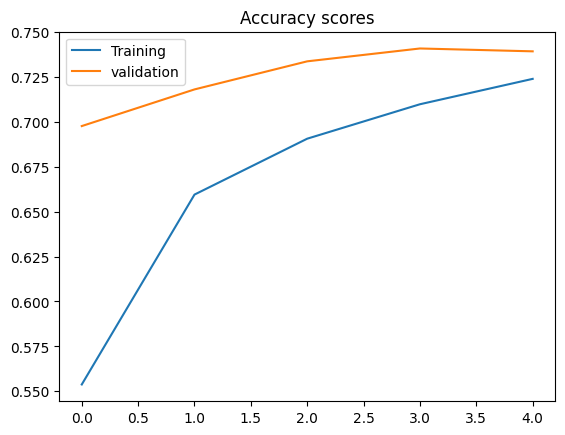

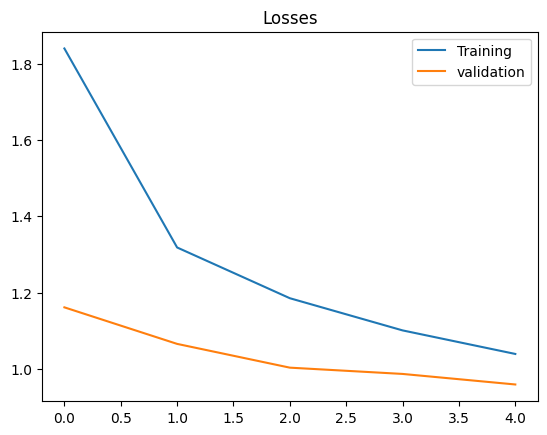

In [26]:
plot_history(feature_extraction_history)

In [27]:
base_model.trainable = True


for layer in base_model.layers[:-20]:
  layer.trainable = False

In [28]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetv2-b0 True
globalAvgPooling_layer True
output_layer True
prediction True


In [30]:
for num,layer in enumerate(model.layers[1].layers):
  print(num,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [32]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

lets train the model

In [33]:
best_model = model.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(.15 * len(test_data)),
                       callbacks=[create_tensorboard_callback('models','best_fine_effb0'),
                                  early_stopping,reduce_lr,model_checkpoint])

Epoch 1/100
2368/2368 [==============================] - 219s 86ms/step - loss: 1.0192 - accuracy: 0.7337 - val_loss: 0.8764 - val_accuracy: 0.7624 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 211s 89ms/step - loss: 0.8721 - accuracy: 0.7689 - val_loss: 0.8270 - val_accuracy: 0.7744 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 204s 85ms/step - loss: 0.7911 - accuracy: 0.7884 - val_loss: 0.7999 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 204s 85ms/step - loss: 0.7273 - accuracy: 0.8059 - val_loss: 0.7911 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 205s 86ms/step - loss: 0.6751 - accuracy: 0.8193 - val_loss: 0.7749 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 204s 85ms/step - loss: 0.6238 - accuracy: 0.8337 - val_loss: 0.7726 - val_accuracy: 0.7913 - lr: 1.0000e-04
Epoch 7/10

In [34]:
best_results = model.evaluate(test_data)
best_results

790/790 [==============================] - 50s 64ms/step - loss: 0.7487 - accuracy: 0.7956


[0.7487245798110962, 0.7956039309501648]

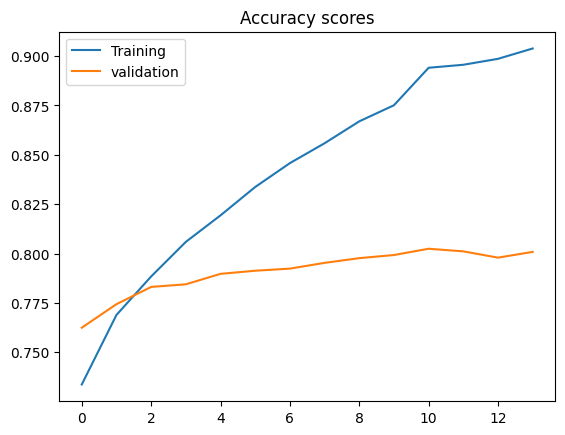

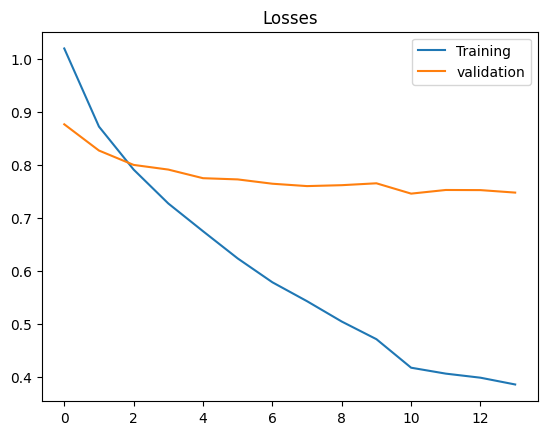

In [35]:
plot_history(best_model)